# Results Summaries + Plots

In [85]:
import json, os
import seaborn as sns  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv();

## Load Results

### OOD Eval

For each mapping type we are going to create a dataframe whose rows are the relation types, with the last three rows representing the micro, macro, and weighted F1 scores.
The columns are the six domains, then the cross-domain average, then the cross domain average without the news domain.
For cells with 0 corresponding support the value is None.

In [86]:
mapping_types = ["no_mapping", "manual", "embedding", "ood_clustering", "topological", "thesaurus_affinity"]
domains = ["ai", "literature", "music", "politics", "science", "news"]
results_folder_path = "data/results"

# To construct file path
domain_list = "".join([domain[0] for domain in sorted(domains)])

relation_types = sorted(os.getenv(f"RELATION_LABELS").split())
f1_types = ["micro", "macro", "weighted"]

indices = relation_types + [f"{f1_type}_F1" for f1_type in f1_types]
columns = domains + ["average", "avg_wo_news"]

ood_results = {}

for mapping_type in mapping_types:
    result_path = os.path.join(results_folder_path, f"{domain_list}_{mapping_type}", "ood_validation.json")
    with open(result_path) as f:
        result_dict = json.load(f)

    results = pd.DataFrame(0, index=indices, columns=columns)
    # Fill in dataframe
    # Go row-by-row
    for relation_type in relation_types + f1_types:
        if relation_type in f1_types:
            json_name = f"{relation_type} avg"
            result_name = f"{relation_type}_F1"
        else:
            json_name = relation_type
            result_name = relation_type

        # We only want to include specific label-domain score in the avg if its support != 0
        # So let's put them in a list if support != 0, then the length of the list determines the denominator for the mean
        avg_wo_news = []
        for domain in domains + ["average"]:
            if result_dict[domain][json_name]["support"] == 0:
                results.loc[result_name, domain] = None
            else:
                f1 = result_dict[domain][json_name]["f1-score"]
                results.loc[result_name, domain] = f1
                if domain not in ["news", "average"]:
                    avg_wo_news.append(f1)
        avg_wo_news = sum(avg_wo_news) / len(avg_wo_news)
        results.loc[result_name, "avg_wo_news"] = avg_wo_news
    ood_results[mapping_type] = results

In [88]:
sum_measures = ["micro_F1", "macro_F1", "weighted_F1"]
ood_summary = pd.DataFrame(0, index=sum_measures, columns=mapping_types)
for mapping_type in mapping_types:
    for measure in sum_measures:
        ood_summary.loc[measure, mapping_type] = ood_results[mapping_type].loc[measure, "avg_wo_news"]
ood_summary

,no_mapping,manual,embedding,ood_clustering,topological,thesaurus_affinity
micro_F1,0.466878,0.544317,0.510969,0.494620,0.539467,0.548099
macro_F1,0.288376,0.328379,0.303398,0.288007,0.326025,0.327904
weighted_F1,0.435395,0.511465,0.479359,0.462159,0.510325,0.521648


### Cross-Domain Eval

One df, rows are the same as above, columns are mapping types.

In [87]:
mapping_types_cd_eval = [mapping_type for mapping_type in mapping_types if mapping_type != "ood_clustering"]
cd_results = pd.DataFrame(0, index=indices, columns=mapping_types_cd_eval)
for mapping_type in mapping_types_cd_eval:
    result_path = os.path.join(results_folder_path, f"{domain_list}_{mapping_type}", "all.json")
    with open(result_path) as f:
        result_dict = json.load(f)
    # Fill in dataframe
    # Go row-by-row
    for relation_type in relation_types + f1_types:
        if relation_type in f1_types:
            json_name = f"{relation_type} avg"
            result_name = f"{relation_type}_F1"
        else:
            json_name = relation_type
            result_name = relation_type
        if result_dict["average"][json_name]["support"] == 0:
            cd_results.loc[result_name, mapping_type] = None
        else:
            cd_results.loc[result_name, mapping_type] = result_dict["average"][json_name]["f1-score"]

In [92]:
cd_summary = cd_results.iloc[-3:]
cd_summary

,no_mapping,manual,embedding,topological,thesaurus_affinity
micro_F1,0.639771,0.643988,0.633692,0.631987,0.641095
macro_F1,0.452749,0.467648,0.448746,0.463378,0.461635
weighted_F1,0.618562,0.621940,0.611512,0.613782,0.619818


## Previous

In [2]:
# Read function
def load_result_json(mapping_method, ood=False):
    ## create path
    path = f"data/results/almnps_{mapping_method}/"
    
    ## open ood or all
    if ood:
        path += "ood_validation.json"
    else:
        path += "all.json"
    
    ## open json file and read
    file = open(path, "r")
    results = json.load(file)
    file.close()
    
    return results

In [3]:
# flags 
with_news = False

In [4]:
envs = dotenv.dotenv_values()
list_of_relations = envs["RELATION_LABELS"].split(" ")
list_of_relations.sort()

## load file 
results_for_method = load_result_json("embedding", ood=True)

# list of domians
domains = list(results_for_method.keys())[2:]
if not with_news:
    domains.remove("news")

# create shape of array to use in functions 
shape_of_array = (len(list_of_relations), len(domains))

In [5]:
shape_of_array

(17, 5)

### Helper functions

In [6]:
def get_ood_f1_scores(results):

    ## create empty array
    data = np.empty(shape_of_array)

    ## loop over domains
    for i, domain in enumerate(domains):

        ## loop over relations    
        for j, relation in enumerate(list_of_relations):
            
            ## get support for relation
            support = results[domain][relation]["support"]

            if support == 0: # if support is 0, then f1-score is 0
                data[j,i] = None
            else: # if the relation is in the domain

                ## get f1 score and add to array
                data[j,i] = results[domain][relation]["f1-score"]
    
    return data

def get_total_support_for_domain(results, domain):
    
    total_support = 0
    
    ## loop over relations
    for relation in list_of_relations:
        
        ## get support for relation
        support = results[domain][relation]["support"]
        
        ## add to total support
        total_support += support
    
    return total_support

def weighted_f1_score(results):
    
    weighted_f1 = []

    ## get all f1 scores to use in calculations
    all_f1_scores = get_ood_f1_scores(results)
    
    ## for each domains calculate weighted f1-score
    for i, domain in enumerate(domains):
        
        total_support = get_total_support_for_domain(results, domain)
        weighted_f1_domain = 0
        
        for j, relation in enumerate(list_of_relations):
            
            ## get support for relation
            support = results[domain][relation]["support"]

            if support == 0: # if support is 0, then f1-score is 0
                pass
            else: # if the relation is in the domain

                ## calculate weight
                weight = support / total_support
                
                ## get f1-score
                f1_relation = all_f1_scores[j][i]
                
                ## add to weighted f1-score
                weighted_f1_domain += weight * f1_relation

        weighted_f1.append(weighted_f1_domain)

    return weighted_f1    

def plot_weighted_f1_score_as_bar(results):
    weighted_f1 = weighted_f1_score(results)
    plt.figure(figsize=(10, 5))
    plt.bar(domains, weighted_f1)
    plt.title("Weighted F1-score for each domain")
    plt.xlabel("Domain")
    plt.ylabel("Weighted F1-score")
    plt.show()

def plot_heat_map(results, domains, transposed=False, mapping=None):
    
    data = get_ood_f1_scores(results)
    
    plt.figure(figsize=(8, 5))
    
    xticklabels = domains
    yticklabels = list_of_relations 
    
    if transposed:
        data = data.transpose()
        xticklabels = list_of_relations
        yticklabels = domains
    ## create color map
    cmap = mpl.cm.YlGn
    cmap.set_bad("grey")

    ## plot heatmap
    ax = sns.heatmap(data, annot=True, cmap=cmap , xticklabels=xticklabels, yticklabels=yticklabels, vmin=0, vmax=1.0)
    ax.set_title(f"F1-score for each relation with {mapping}")
    
    # plt.show()
    if mapping is not None:
        fig = ax.get_figure()
        fig.savefig(f"figures/{mapping}_heatmap.png", bbox_inches='tight')
        #ax.savefig(f"figures/{mapping}_heatmap.png")

def plot_heat_map_mapping_ood(mapping, transposed=False):
    ## load file 
    results_for_method = load_result_json(mapping, ood=True)
    # plotting
    plot_heat_map(results_for_method, domains, transposed=transposed, mapping=mapping)

def plot_heat_map_compared_to_baseline(results_mapping, results_baseline ,domains, transposed=False, mapping=None):

    data_mapping = get_ood_f1_scores(results_mapping)
    data_baseline = get_ood_f1_scores(results_baseline)

    data = data_mapping - data_baseline
    
    plt.figure(figsize=(8, 5))
    
    xticklabels = domains
    yticklabels = list_of_relations 
    
    if transposed:
        data = data.transpose()
        xticklabels = list_of_relations
        yticklabels = domains
    ## create color map
    cmap = mpl.cm.seismic_r
    cmap.set_bad("grey")

    ## plot heatmap
    ax = sns.heatmap(data, annot=True, cmap=cmap , xticklabels=xticklabels, yticklabels=yticklabels, vmax=0.5, vmin=-0.5)
    ax.set_title(f"F1-score difference for {mapping} compared to baseline")
    
    # plt.show()
    if mapping is not None:
        fig = ax.get_figure()
        fig.savefig(f"figures/{mapping}_heatmap_diff.png", bbox_inches='tight')
        #ax.savefig(f"figures/{mapping}_heatmap.png")

def plot_heat_map_mapping_ood_compared_to_baseline(mapping, transposed):
    ## load file
    results_for_method = load_result_json(mapping, ood=True)
    results_for_baseline = load_result_json("no_mapping", ood=True)

    plot_heat_map_compared_to_baseline(results_for_method, results_for_baseline, domains, transposed=transposed, mapping=mapping)
    


### plotting

In [8]:
weighted_f1 = weighted_f1_score(results_for_method)

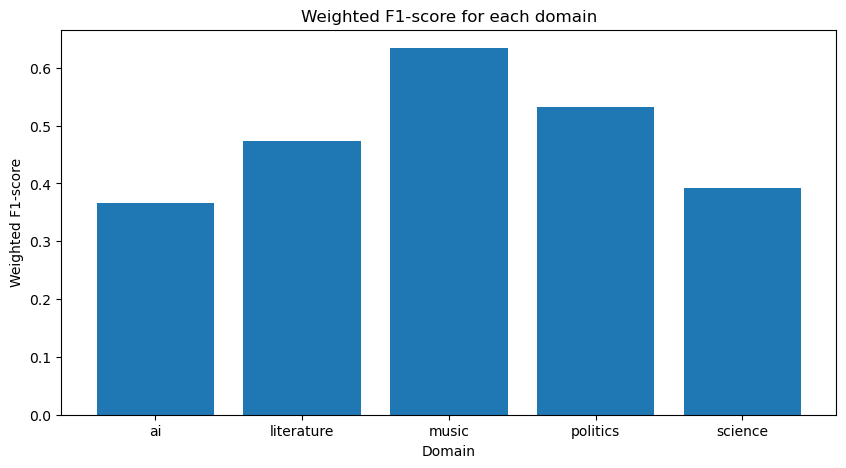

In [9]:
plot_weighted_f1_score_as_bar(results_for_method)

## OOD 

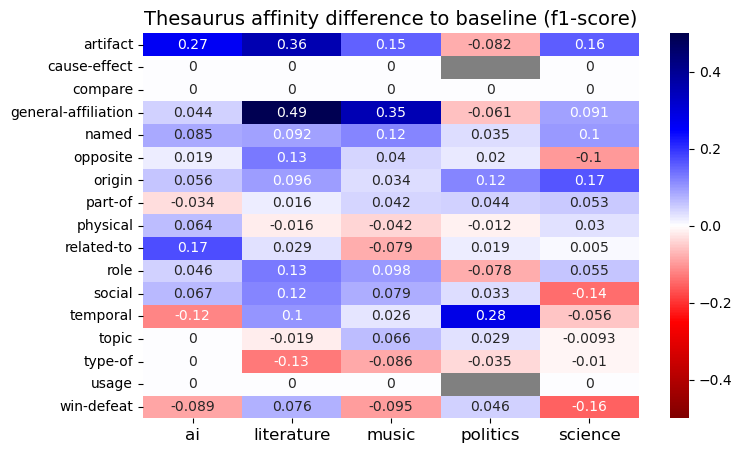

In [10]:
results_for_affinity = load_result_json("thesaurus_affinity", ood=True)
results_for_baseline = load_result_json("no_mapping", ood=True)
data_affinity = get_ood_f1_scores(results_for_affinity)
data_baseline = get_ood_f1_scores(results_for_baseline)
diff = data_affinity - data_baseline

cmap = mpl.cm.seismic_r
cmap.set_bad("grey")


ax = sns.heatmap(diff,annot=True ,cmap=cmap, xticklabels=domains, yticklabels=list_of_relations, vmax=0.5, vmin=-0.5)
ax.figure.set_size_inches(8,5)
ax.set_xticklabels(domains, fontsize=12)
ax.set_yticklabels(list_of_relations, fontsize=10)
ax.set_title("Thesaurus affinity difference to baseline (f1-score)", fontsize=14)
plt.savefig("figures/Thesaurus_affinity_diff_to_baseline.png", bbox_inches='tight')

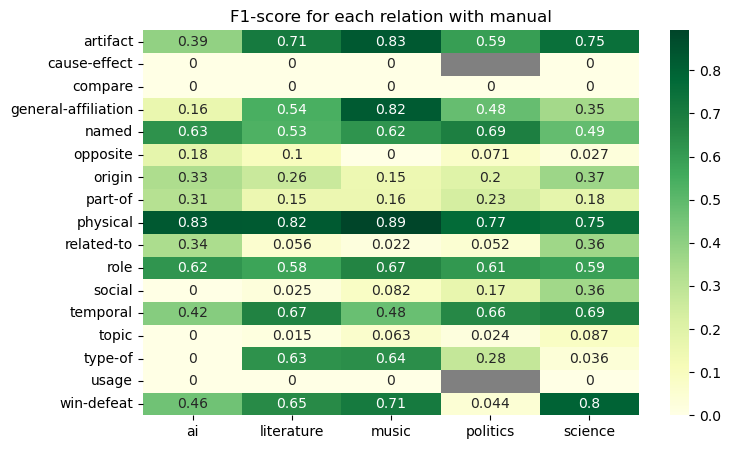

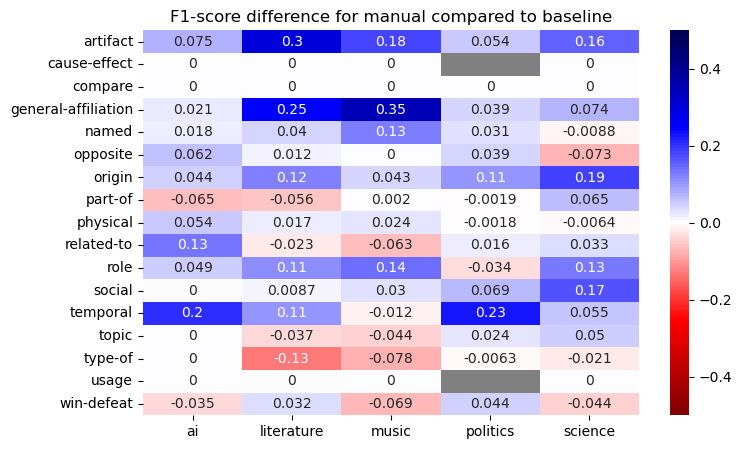

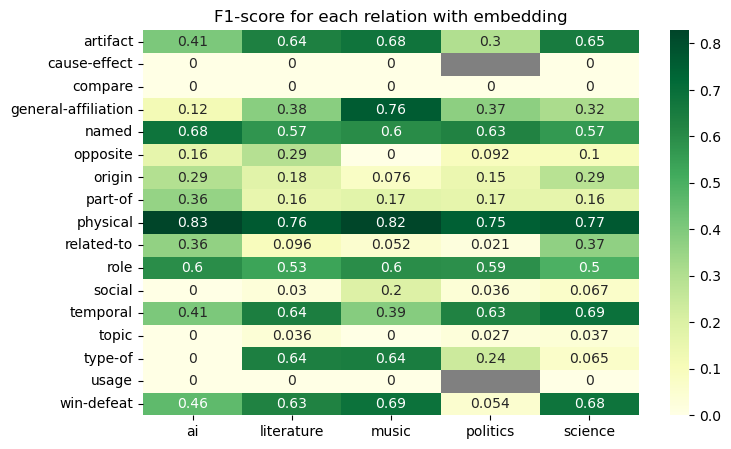

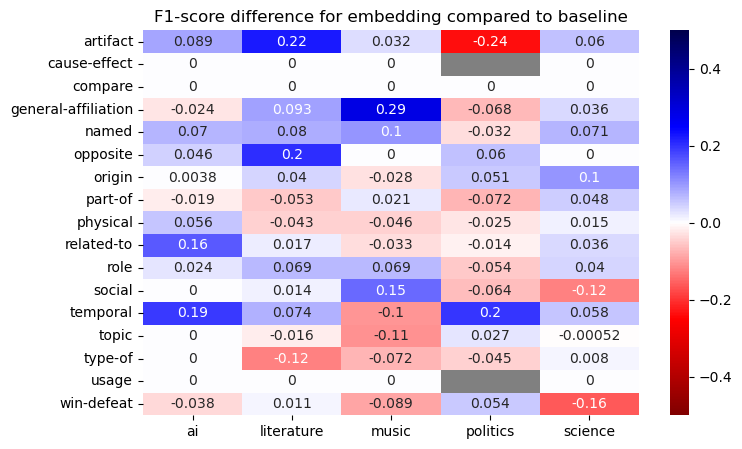

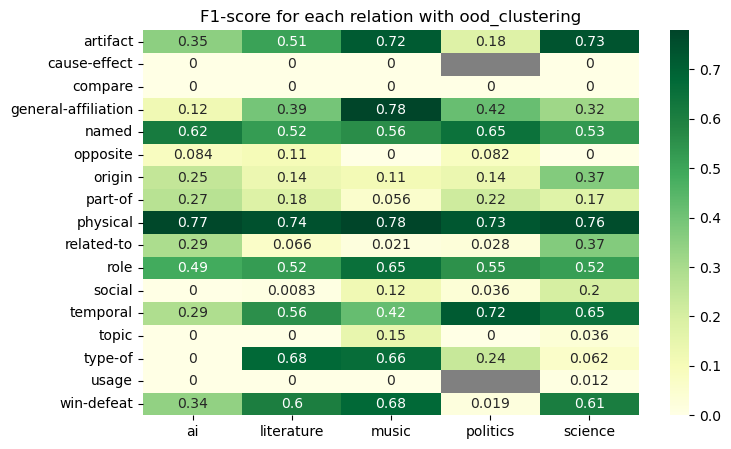

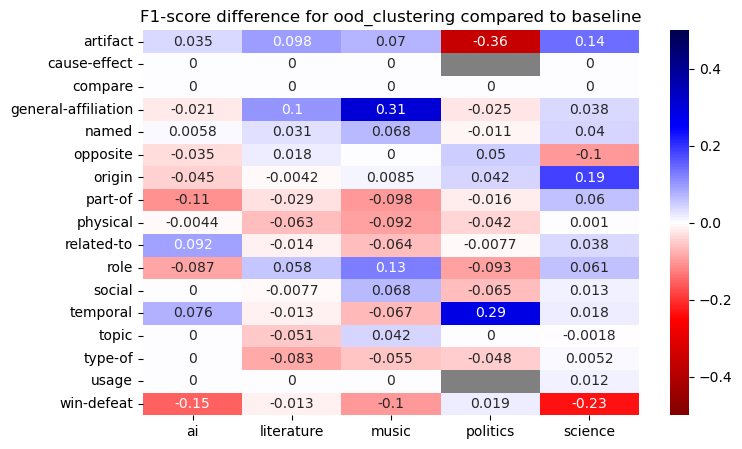

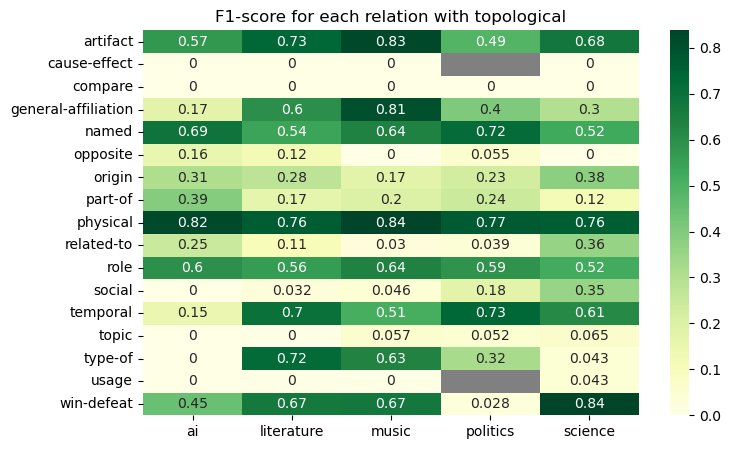

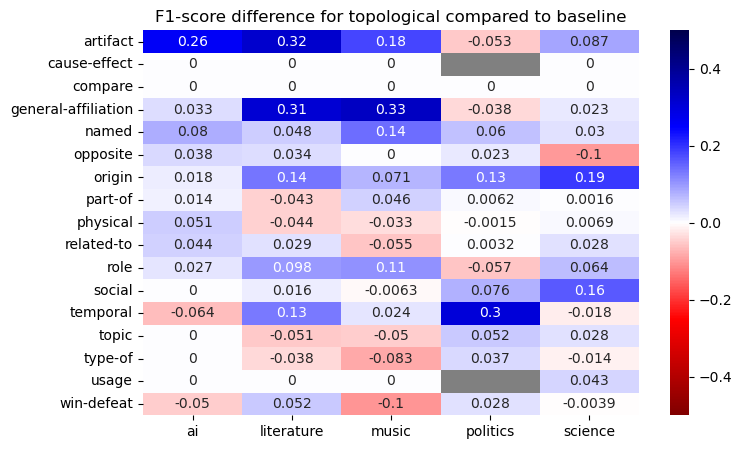

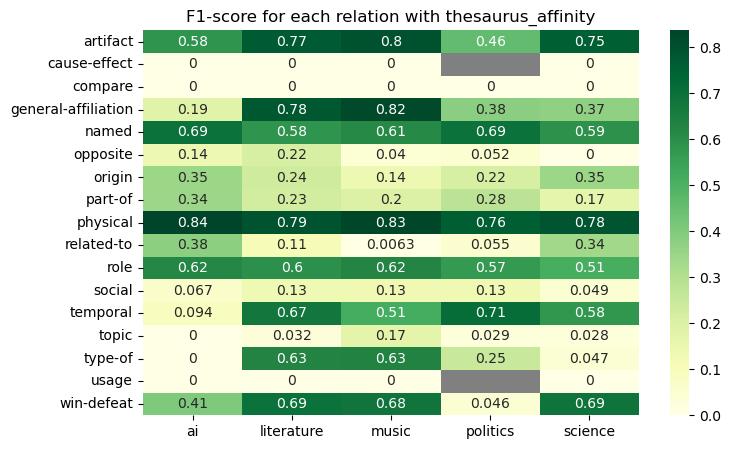

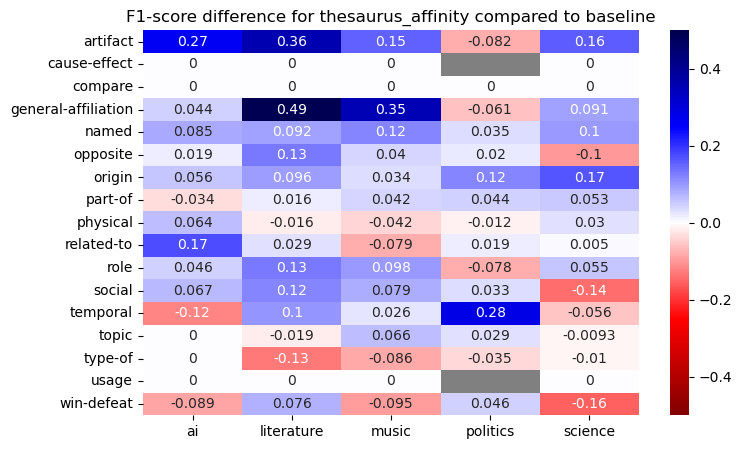

In [11]:
mapping_types = ["manual", "embedding", "ood_clustering", "topological", "thesaurus_affinity"]
for m in mapping_types:
    plot_heat_map_mapping_ood(m, transposed=False)
    plot_heat_map_mapping_ood_compared_to_baseline(m, transposed=False)

Matrix For  no_mapping
Matrix For  manual
Matrix For  embedding
Matrix For  ood_clustering
Matrix For  topological
Matrix For  thesaurus_affinity


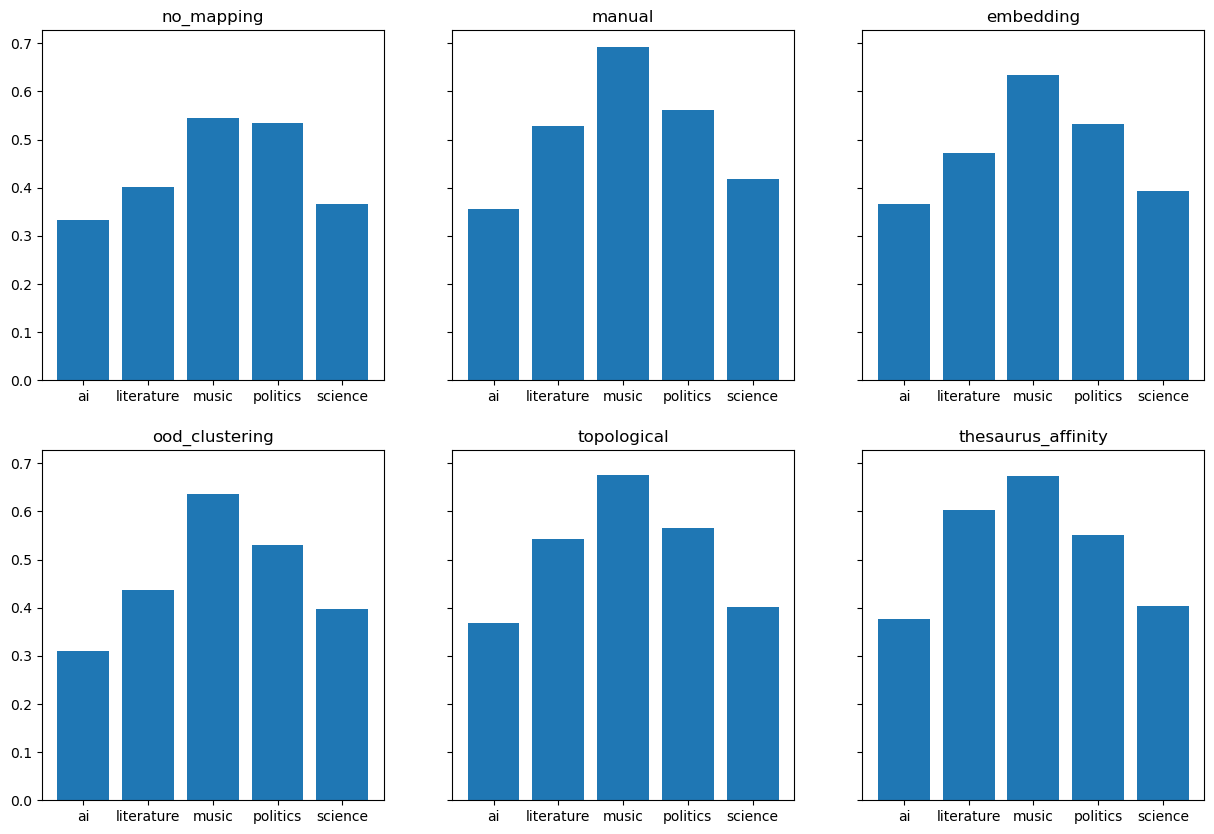

In [12]:
mapping_types = ["no_mapping", "manual", "embedding", "ood_clustering", "topological", "thesaurus_affinity"]

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

for idx, m in enumerate(mapping_types):
    print("Matrix For ", m)
    row = idx // 3
    column  = idx % 3
    results_for_method = load_result_json(m, ood=True)

    weighted_f1 = weighted_f1_score(results_for_method)

    ax[row, column].bar(domains, weighted_f1)
    ax[row, column].set_title(m)

In [13]:
df = pd.DataFrame(index=mapping_types, columns=domains)

In [14]:
df_1 = pd.DataFrame(index=domains, columns=mapping_types)

In [15]:
for m in mapping_types:
    
    results_for_method = load_result_json(m, ood=True)
    
    weighted_f1 = weighted_f1_score(results_for_method)
    
    for i, d in enumerate(domains):
        
        df_1[m][d] = weighted_f1[i]

In [16]:
mapping_methods = list(df_1.keys())


In [17]:
df_1

,no_mapping,manual,embedding,ood_clustering,topological,thesaurus_affinity
ai,0.332988,0.356331,0.365714,0.310875,0.367625,0.377087
literature,0.400663,0.529206,0.472721,0.43743,0.543226,0.603784
music,0.543984,0.692433,0.634154,0.635634,0.674726,0.673843
politics,0.533977,0.561604,0.531828,0.52941,0.5648,0.550881
science,0.365363,0.417752,0.392377,0.397397,0.401249,0.402643


In [18]:

data_dict = df_1.to_dict()

data_dict["no_mapping"]

{'ai': 0.33298799482860764,
 'literature': 0.4006629580567793,
 'music': 0.5439841260710191,
 'politics': 0.5339769321562913,
 'science': 0.3653627114523133}

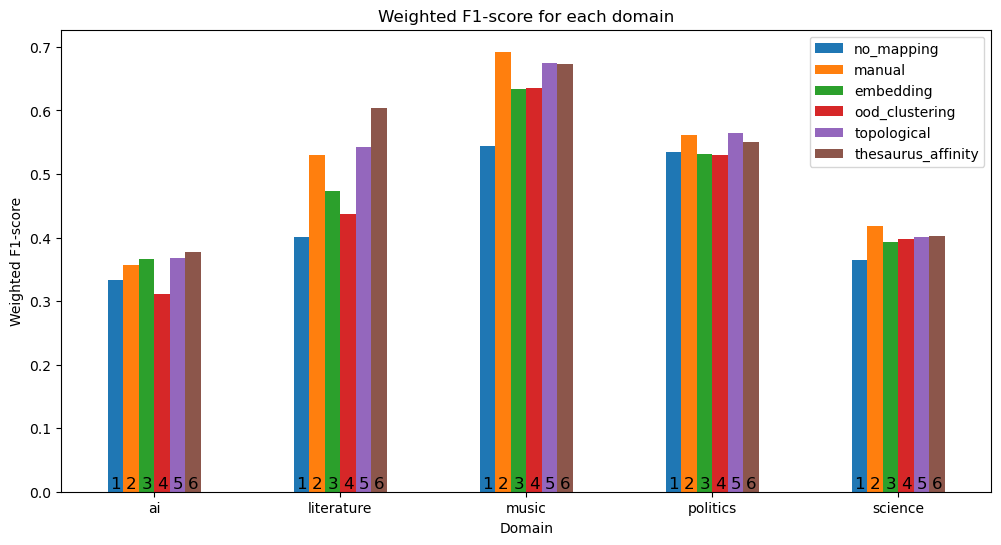

In [19]:
color_1 = ["hotpink", "lightsteelblue", "green", "midnightblue", "mediumturquoise", "blue"]
ax = df_1.plot.bar(rot=0, figsize=(12, 6), title="Weighted F1-score for each domain", ylabel="Weighted F1-score", xlabel="Domain")

for idx, bar in enumerate(ax.patches):
    # The text annotation for each bar should be its height.
    bar_value = bar.get_height()
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{idx // 5 +1}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + 0
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = bar.get_facecolor()
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color="black",
            size=12)


## All 

In [20]:
all = load_result_json("no_mapping", ood=False)

In [21]:
def get_all_f1_scores(results):
    
    f1_scores = []
    for relation in list_of_relations:
        
        f1_score = results["average"][relation]["f1-score"]
        
        support = results["average"][relation]["support"]
        if support == 0:
            f1_score.append(None)
            print("support is 0")
        else:
            f1_scores.append(f1_score)

    return f1_scores

In [22]:
mapping_types_for_all = ["no_mapping", "manual", "embedding", "topological", "thesaurus_affinity"]

In [23]:
all_mapping_f1_scores = []
for m in mapping_types_for_all:
    if m != "ood_clustering":    
        print("Matrix For ", m)
        results_for_method = load_result_json(m, ood=False)

        all_f1_scores = get_all_f1_scores(results_for_method)
        
        all_mapping_f1_scores.append(all_f1_scores)

Matrix For  no_mapping
Matrix For  manual
Matrix For  embedding
Matrix For  topological
Matrix For  thesaurus_affinity


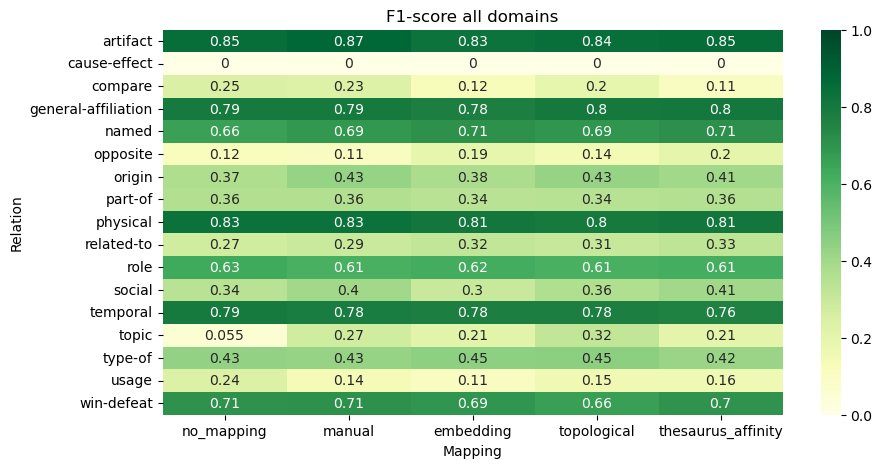

In [24]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    np.transpose(all_mapping_f1_scores),
    xticklabels=mapping_types_for_all,
    yticklabels=list_of_relations,
    cmap="YlGn", annot=True, vmin=0, vmax=1)
plt.title("F1-score all domains")
plt.xlabel("Mapping")
plt.ylabel("Relation")
plt.savefig("figures/all_f1_scores.png")

In [25]:
def get_all_support(results):
    list_of_support = []
    for relation in list_of_relations:
        support = results["average"][relation]["support"]
        list_of_support.append(support)
    return list_of_support

## weighted f1-score for each mappingn method in all
def get_weighted_f1_for_mapping_method(results):

    all_f1 = get_all_f1_scores(results)

    all_support = get_all_support(results)

    total_support = sum(all_support)

    weighted_f1 = 0
    
    for f1, support in zip(all_f1, all_support):
        if support == 0:
            print("support is 0")
            continue
        weighted_f1 += f1 * (support / total_support)

    return weighted_f1

def get_weighted_f1_for_all_mapping_methods():
    weighted_f1_scores = []
    for m in mapping_types_for_all:
        
        results_for_method = load_result_json(m, ood=False)

        weighted_f1 = get_weighted_f1_for_mapping_method(results_for_method)

        weighted_f1_scores.append(weighted_f1)
    return weighted_f1_scores

In [26]:
weighted_f1_mapping = []
for m in mapping_types_for_all:

    results_for_method = load_result_json(m, ood=False)

    weighted_f1 = get_weighted_f1_for_mapping_method(results_for_method)

    weighted_f1_mapping.append(weighted_f1)


In [27]:
results_for_method = load_result_json("topological", ood=True)


In [28]:
for m in mapping_types:
    results_for_method = load_result_json(m, ood=True)
    result = results_for_method["average"]["weighted avg"]["f1-score"]
    

In [29]:
for m in mapping_types:
    results_for_method = load_result_json(m, ood=True)
    result = get_weighted_f1_for_mapping_method(results_for_method)
    print(result)


0.4273803055282326
0.4760873694494247
0.4392313665671374
0.4335148484270309
0.4719951425018325
0.47823788883410906
